# imports

# cifar10 test

In [3]:
RUNS_DIR = "/home/adam/src/features-across-time/runs"

Step 1: 0.100


Step 2: 0.100


Step 4: 0.100


Step 8: 0.104


Step 16: 0.141


Step 32: 0.145


Step 64: 0.166


Step 128: 0.189


Step 256: 0.320


Step 512: 0.399


Step 1024: 0.449


Step 2048: 0.528


Step 4096: 0.733


Step 8192: 0.835


Step 16384: 0.883


Step 32768: 0.909


100%|██████████| 17/17 [00:47<00:00,  2.81s/it]

Step 65536: 0.930


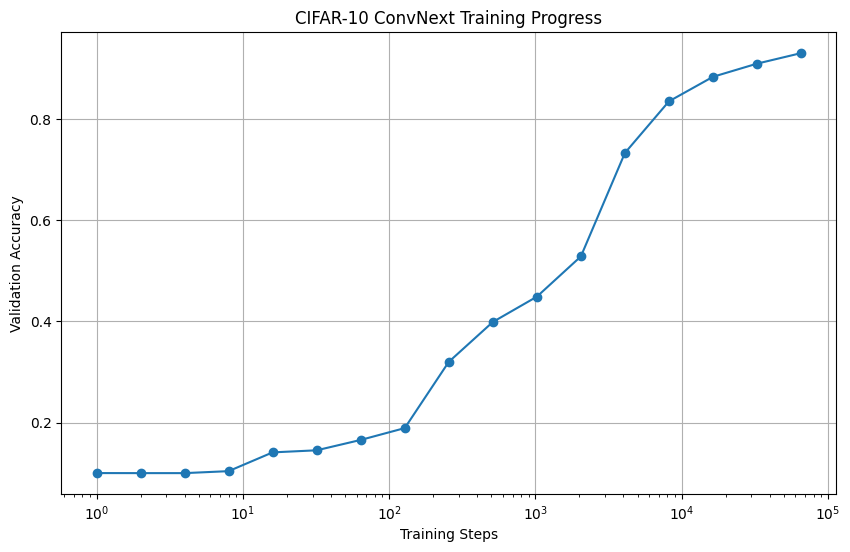

In [8]:
from pathlib import Path
import torch
from datasets import load_dataset
from transformers import ConvNextV2ForImageClassification, ConvNextV2Config
from torch.utils.data import DataLoader
import torchvision.transforms as T
import matplotlib.pyplot as plt
from tqdm import tqdm

ds = load_dataset("cifar10")
val_ds = ds["test"]

transform = T.Compose([
    T.ToTensor(),
])

def preprocess(examples):
    return {
        "pixel_values": [transform(image.convert("RGB")) for image in examples["img"]],
        "label": examples["label"]
    }

val_ds = val_ds.map(preprocess, batched=True, remove_columns=val_ds.column_names)
val_ds.set_format(type="torch")

val_loader = DataLoader(val_ds, batch_size=128, num_workers=4)

checkpoints = sorted(
    Path(RUNS_DIR, "cifar10", "convnext").glob("checkpoint-*"), 
    key=lambda x: int(x.name.split("-")[1])
)

accuracies = []
steps = []

for ckpt in tqdm(checkpoints):
    config = ConvNextV2Config.from_pretrained(ckpt)
    model = ConvNextV2ForImageClassification.from_pretrained(
        ckpt,
        config=config,
        torch_dtype=torch.float16
    ).cuda()
    model.eval()
    
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch in val_loader:
            pixel_values = batch["pixel_values"].cuda().to(torch.float16)
            labels = batch["label"].cuda()
            
            outputs = model(pixel_values)
            predictions = outputs.logits.argmax(-1)
            
            correct += (predictions == labels).sum().item()
            total += labels.size(0)
    
    accuracy = correct / total
    step = int(ckpt.name.split("-")[1])
    accuracies.append(accuracy)
    steps.append(step)
    print(f"Step {step}: {accuracy:.3f}")

plt.figure(figsize=(10, 6))
plt.semilogx(steps, accuracies, "-o")
plt.grid(True)
plt.xlabel("Training Steps")
plt.ylabel("Validation Accuracy")
plt.title("CIFAR-10 ConvNext Training Progress")
plt.show()

Step 1: Train acc: 0.100

, Val acc: 0.100
Step 2: Train acc: 0.100

, Val acc: 0.100
Step 4: Train acc: 0.100

, Val acc: 0.100
Step 8: Train acc: 0.103

, Val acc: 0.104
Step 16: Train acc: 0.137

, Val acc: 0.141
Step 32: Train acc: 0.141

, Val acc: 0.145
Step 64: Train acc: 0.166

, Val acc: 0.166
Step 128: Train acc: 0.196

, Val acc: 0.189
Step 256: Train acc: 0.318

, Val acc: 0.320
Step 512: Train acc: 0.396

, Val acc: 0.399
Step 1024: Train acc: 0.448

, Val acc: 0.449
Step 2048: Train acc: 0.540

, Val acc: 0.528
Step 4096: Train acc: 0.761

, Val acc: 0.733
Step 8192: Train acc: 0.876

, Val acc: 0.835
Step 16384: Train acc: 0.957

, Val acc: 0.883
Step 32768: Train acc: 0.996

, Val acc: 0.909
Step 65536: Train acc: 1.000

100%|██████████| 17/17 [04:19<00:00, 15.26s/it]

, Val acc: 0.930


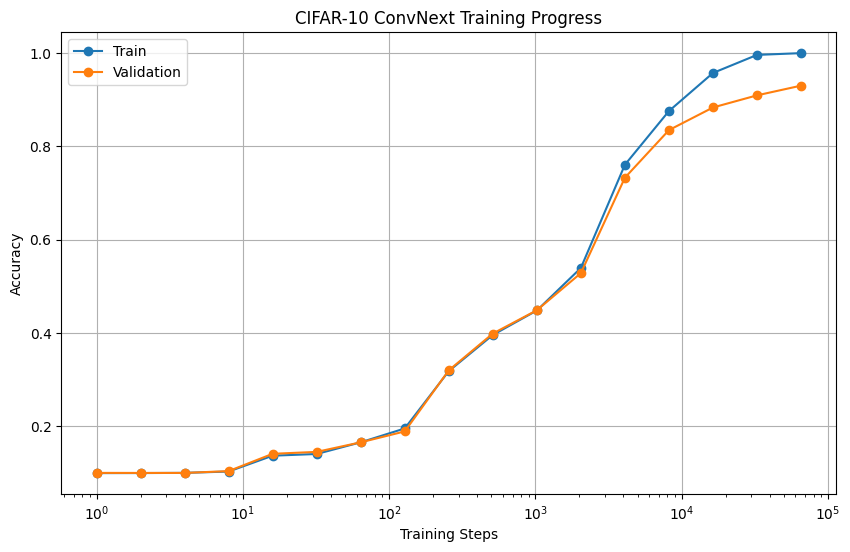

In [10]:
from pathlib import Path
import torch
from datasets import load_dataset
from transformers import ConvNextV2ForImageClassification, ConvNextV2Config
from torch.utils.data import DataLoader
import torchvision.transforms as T
import matplotlib.pyplot as plt
from tqdm import tqdm

# Load and process both train and val sets
ds = load_dataset("cifar10")
train_ds = ds["train"]
val_ds = ds["test"]

transform = T.Compose([T.ToTensor()])

def preprocess(examples):
    return {
        "pixel_values": [transform(image.convert("RGB")) for image in examples["img"]],
        "label": examples["label"]
    }

train_ds = train_ds.map(preprocess, batched=True, remove_columns=train_ds.column_names)
val_ds = val_ds.map(preprocess, batched=True, remove_columns=val_ds.column_names)
train_ds.set_format(type="torch")
val_ds.set_format(type="torch")

train_loader = DataLoader(train_ds, batch_size=128, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=128, num_workers=4)

checkpoints = sorted(
    Path(RUNS_DIR, "cifar10", "convnext").glob("checkpoint-*"), 
    key=lambda x: int(x.name.split("-")[1])
)

train_accuracies = []
val_accuracies = []
steps = []

for ckpt in tqdm(checkpoints):
    config = ConvNextV2Config.from_pretrained(ckpt)
    model = ConvNextV2ForImageClassification.from_pretrained(
        ckpt,
        config=config,
        torch_dtype=torch.float16
    ).cuda()
    model.eval()
    
    # Evaluate on both sets
    for loader, accuracies in [(train_loader, train_accuracies), (val_loader, val_accuracies)]:
        correct = 0
        total = 0
        
        with torch.no_grad():
            for batch in loader:
                pixel_values = batch["pixel_values"].cuda().to(torch.float16)
                labels = batch["label"].cuda()
                
                outputs = model(pixel_values)
                predictions = outputs.logits.argmax(-1)
                
                correct += (predictions == labels).sum().item()
                total += labels.size(0)
        
        accuracy = correct / total
        if loader == train_loader:  # Only add steps once
            step = int(ckpt.name.split("-")[1])
            steps.append(step)
            print(f"Step {step}: Train acc: {accuracy:.3f}", end="")
        else:
            print(f", Val acc: {accuracy:.3f}")
        accuracies.append(accuracy)

plt.figure(figsize=(10, 6))
plt.semilogx(steps, train_accuracies, "-o", label="Train")
plt.semilogx(steps, val_accuracies, "-o", label="Validation")
plt.grid(True)
plt.xlabel("Training Steps")
plt.ylabel("Accuracy")
plt.title("CIFAR-10 ConvNext Training Progress")
plt.legend()
plt.show()